In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import sklearn
sklearn.set_config(print_changed_only=True)

# Algorithm Chains and Pipelines

In [3]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# load and split the data
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)
# rescale training data
X_train_scaled = scaler.transform(X_train)

# instantiate the SVC
svm = SVC()
# learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)

# scale test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print('score: ', svm.score(X_test_scaled, y_test))

score:  0.951048951048951


### Building Pipelines

In [4]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), 
                 ("svm", SVC())])

In [5]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [6]:
print('score: ', pipe.score(X_test, y_test))

score:  0.951048951048951


### Using Pipelines in Grid-searches

In [8]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [9]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipe, param_grid=param_grid)
grid.fit(X_train, y_train)

print("best cv accuracy:", grid.best_score_)
print("test set score:  ", grid.score(X_test, y_test))
print("best parameters: ", grid.best_params_)

best cv accuracy: 0.9788732394366197
test set score:   0.965034965034965
best parameters:  {'svm__C': 10, 'svm__gamma': 0.1}


# Not using Pipelines vs feature selection

In [12]:
# creating some random data w/ a normalized distribution
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

print(X.shape)

(100, 10000)


In [20]:
from sklearn.feature_selection import SelectPercentile, f_regression

# select 5% of the 10,000 features
select = SelectPercentile(score_func=f_regression,
                          percentile=5)

select.fit(X, y)

X_selected = select.transform(X)

print(X_selected.shape)

(100, 500)


In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

print('mean cv score: ', np.mean(cross_val_score(Ridge(), X_selected, y)))

mean cv score:  0.9053548169231332


In [22]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)),
                 ("ridge", Ridge())])

print('mean pipelined cv score: ', np.mean(cross_val_score(pipe, X, y)))

mean pipelined cv score:  -0.09090078645251894


### The General Pipeline Interface

In [23]:
def fit(self, X, y):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # fit and transform the data
        X_transformed = step[1].fit_transform(X_transformed, y)
    # fit the last step
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [24]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # iterate over all but the final step
        # transform the data
        X_transformed = step[1].transform(X_transformed)
    # predict using the last step
    return self.steps[-1][1].predict(X_transformed)

### Convenient Pipeline creation with ``make_pipeline``

In [25]:
from sklearn.pipeline import make_pipeline

# standard syntax
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])

# abbreviated syntax
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [26]:
pipe_short.steps

[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2),
                     StandardScaler())
pipe.steps

[('standardscaler-1', StandardScaler()),
 ('pca', PCA(n_components=2)),
 ('standardscaler-2', StandardScaler())]

#### Accessing step attributes

In [28]:
# fit the pipeline defined above to the cancer dataset
pipe.fit(cancer.data)

# extract the first two principal components from the "pca" step
components = pipe.named_steps.pca.components_

print(components.shape)

(2, 30)


In [29]:
pipe['standardscaler-1']

StandardScaler()

In [30]:
pipe[0]

StandardScaler()

In [31]:
pipe[1]

PCA(n_components=2)

In [32]:
pipe[:2]

Pipeline(steps=[('standardscaler-1', StandardScaler()),
                ('pca', PCA(n_components=2))])

#### Accessing attributes in grid-searched pipeline.

In [33]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [34]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)

grid = GridSearchCV(pipe, param_grid)
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [36]:
print(grid.best_estimator_)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.1))])


In [37]:
print(grid.best_estimator_.named_steps.logisticregression)
print(grid.best_estimator_['logisticregression'])

LogisticRegression(C=0.1)
LogisticRegression(C=0.1)


In [38]:
print(grid.best_estimator_.named_steps.logisticregression)

LogisticRegression(C=0.1)


In [39]:
print(grid.best_estimator_.named_steps.logisticregression.coef_)

[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


### Grid-searching preprocessing steps and model parameters

In [40]:
from sklearn.datasets import load_boston

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state=0)

from sklearn.preprocessing import PolynomialFeatures

pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())

In [41]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [42]:
grid = GridSearchCV(pipe, param_grid=param_grid,
                    n_jobs=-1, return_train_score=True)

grid.fit(X_train, y_train)

C:\Users\jfields\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

In [43]:
res = pd.DataFrame(grid.cv_results_)

res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__degree,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.007314,0.001880,0.001995,8.485379e-07,1,0.001,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.699620,0.635900,0.766713,0.700741,0.053340,8,0.785248,0.806420,0.745943,0.779204,0.025057
1,0.006981,0.000001,0.001329,4.691225e-04,1,0.01,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.699633,0.635899,0.766726,0.700750,0.053345,7,0.785248,0.806420,0.745943,0.779204,0.025057
2,0.003989,0.001411,0.001002,4.979595e-06,1,0.1,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.699770,0.635892,0.766851,0.700835,0.053398,6,0.785248,0.806419,0.745942,0.779203,0.025057
3,0.003658,0.001695,0.001662,4.697970e-04,1,1,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.701073,0.635826,0.767937,0.701611,0.053864,5,0.785210,0.806400,0.745868,0.779159,0.025080
4,0.002660,0.000482,0.001324,4.744721e-04,1,10,"{'polynomialfeatures__degree': 1, 'ridge__alph...",0.710295,0.635324,0.770265,0.705308,0.055131,4,0.783073,0.805198,0.742279,0.776850,0.026061


In [44]:
res = pd.pivot_table(res, index=['param_polynomialfeatures__degree', 'param_ridge__alpha'],
               values=['mean_train_score', 'mean_test_score'])

In [45]:
res['mean_test_score'].unstack()

param_ridge__alpha,0.001,0.010,0.100,1.000,10.000,100.000
param_polynomialfeatures__degree,,,,,,
1,0.700741,0.700750,0.700835,0.701611,0.705308,0.691848
2,0.545509,0.555485,0.610549,0.691906,0.816480,0.794729
3,-20.556243,-1.716842,-0.426100,-3.254841,-0.887323,0.771725


In [46]:
res['mean_train_score'].unstack()

param_ridge__alpha,0.001,0.010,0.100,1.000,10.000,100.000
param_polynomialfeatures__degree,,,,,,
1,0.779204,0.779204,0.779203,0.779159,0.776850,0.740652
2,0.964682,0.964372,0.963114,0.958697,0.944745,0.895497
3,0.999985,0.999686,0.998266,0.993743,0.982331,0.959233


In [47]:
print(grid.best_params_)

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [48]:
grid.score(X_test, y_test)

0.768304546410014

In [49]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold

In [50]:
pipe = Pipeline([('scaler', StandardScaler()), ('regressor', Ridge())])

param_grid = {'scaler': [StandardScaler(), MinMaxScaler(), None],
              'regressor': [Ridge(), Lasso()],
              'regressor__alpha': np.logspace(-3, 3, 7)}

grid = GridSearchCV(pipe, param_grid,
                    cv=RepeatedKFold(n_splits=10, n_repeats=10))

grid.fit(X_train, y_train)
grid.score(X_test, y_test)

C:\Users\jfields\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6214583227921033

In [51]:
grid.best_score_

0.7260804016665553

In [52]:
grid.best_params_

{'regressor': Ridge(), 'regressor__alpha': 1.0, 'scaler': MinMaxScaler()}

In [53]:
from sklearn.tree import DecisionTreeRegressor

param_grid = [{'regressor': [DecisionTreeRegressor()],
               'regressor__max_depth': [2, 3, 4]},
              {'regressor': [Ridge()],
               'regressor__alpha': [0.1, 1]}
             ]

# More on ColumnTransformer

In [54]:
from sklearn.compose import make_column_transformer, ColumnTransformer

bike = pd.read_csv("data/bike_day_raw.csv")
bike.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [55]:
bike.dtypes

season          int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object

In [56]:
bike_data = bike.drop("cnt", axis=1)

cat_features = bike.columns[:6]
cat_features

Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], dtype='object')

In [57]:
from sklearn.preprocessing import OneHotEncoder

ct = make_column_transformer((OneHotEncoder(sparse=False), cat_features),
                             remainder=StandardScaler())

ct.transformers

[('onehotencoder',
  OneHotEncoder(sparse=False),
  Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], dtype='object'))]

In [58]:
ColumnTransformer([('ohe', OneHotEncoder(sparse=False), cat_features)],
                  remainder=StandardScaler())

ColumnTransformer([('ohe', OneHotEncoder(sparse=False), cat_features),
                   ('scaler', StandardScaler(), [6, 7, 8, 9])])

ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse=False),
                                 Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], dtype='object')),
                                ('scaler', StandardScaler(), [6, 7, 8, 9])])

In [59]:
ct.fit(bike_data)

ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('onehotencoder', OneHotEncoder(sparse=False),
                                 Index(['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], dtype='object'))])

In [60]:
bike_data.shape

(731, 10)

In [61]:
ct.transform(bike_data).shape

(731, 34)

In [62]:
ct = make_column_transformer((OneHotEncoder(sparse=False), cat_features),
                             remainder=StandardScaler())

ohe_pipe = make_pipeline(ct, Ridge())

In [63]:
X_train, X_test, y_train, y_test = train_test_split(bike_data, bike.cnt, random_state=42)

In [64]:
cross_val_score(ohe_pipe, X_train, y_train)

array([0.50365997, 0.58490916, 0.51495061])

In [65]:
from sklearn.preprocessing import PowerTransformer

ct = make_column_transformer((OneHotEncoder(sparse=False), cat_features))
ohe_pipe = make_pipeline(ct, Ridge())

param_grid = {'columntransformer__remainder':
              [StandardScaler(), PowerTransformer(method='yeo-johnson')],
              'ridge__alpha': np.logspace(-3, 2, 6)}

grid = GridSearchCV(ohe_pipe, param_grid)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.5446847016583231

In [66]:
grid.best_params_

{'columntransformer__remainder': StandardScaler(), 'ridge__alpha': 10.0}

In [67]:
res = pd.DataFrame(grid.cv_results_)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__remainder,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.013961,0.000811,0.006314,0.001695,StandardScaler(),0.001,{'columntransformer__remainder': StandardScale...,0.498702,0.583587,0.507412,0.529941,0.038151,6
1,0.014629,0.005236,0.005490,0.001872,StandardScaler(),0.01,{'columntransformer__remainder': StandardScale...,0.498771,0.583605,0.507494,0.529998,0.038124,5
2,0.007979,0.000814,0.004654,0.000941,StandardScaler(),0.1,{'columntransformer__remainder': StandardScale...,0.499430,0.583781,0.508297,0.530543,0.037870,4
3,0.009974,0.000812,0.005658,0.000936,StandardScaler(),1,{'columntransformer__remainder': StandardScale...,0.503660,0.584909,0.514951,0.534542,0.035960,3
4,0.008977,0.001629,0.006649,0.001244,StandardScaler(),10,{'columntransformer__remainder': StandardScale...,0.507628,0.584942,0.543254,0.545278,0.031624,1
5,0.010308,0.000469,0.006315,0.000943,StandardScaler(),100,{'columntransformer__remainder': StandardScale...,0.459287,0.539565,0.530141,0.509627,0.035851,11
6,0.017286,0.002048,0.004988,0.001410,PowerTransformer(),0.001,{'columntransformer__remainder': PowerTransfor...,0.494293,0.577777,0.498935,0.523713,0.038328,10
7,0.018284,0.002488,0.005654,0.001246,PowerTransformer(),0.01,{'columntransformer__remainder': PowerTransfor...,0.494375,0.577791,0.499043,0.523782,0.038290,9
8,0.016955,0.000814,0.005652,0.001695,PowerTransformer(),0.1,{'columntransformer__remainder': PowerTransfor...,0.495130,0.577915,0.500043,0.524407,0.037940,8
9,0.018283,0.002487,0.004987,0.000815,PowerTransformer(),1,{'columntransformer__remainder': PowerTransfor...,0.499467,0.578445,0.506806,0.528279,0.035648,7


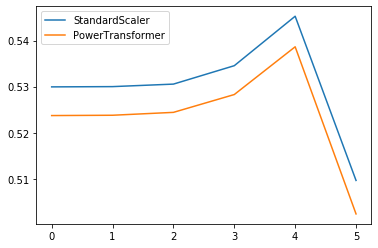

In [68]:
plt.plot(res.mean_test_score[:6].values, label="StandardScaler")
plt.plot(res.mean_test_score[6:].values, label="PowerTransformer")
plt.legend()

# Exercise

Load the adult. Create a pipline using the ColumnTransformer, OneHotEncoder, Scaling, and polynomial features and a linear classifier.

Search over the best options for the polynomial features together with the regularization of a linear model.

In [80]:
df = pd.read_csv("data/adult.csv", index_col=0).head()
df.head(1)
# df.dtypes

,age,workclass,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K


In [81]:
y = df.income
X = df.drop('income', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [82]:
cat_features = df.select_dtypes('object').columns
cat_features = list(cat_features)

In [ ]:
# use OneHotEncoder(handle_unknown='ignore') to ignore new categories in test set.

In [88]:
ct = make_column_transformer((OneHotEncoder(sparse=False, handle_unknown='ignore'), 
                              cat_features))

pipe = Pipeline([('poly', PolynomialFeatures()),
                 ('columntransformer', ct),
                 ('ridge', Ridge())])

param_grid = {'columntransformer__remainder': [StandardScaler(), MinMaxScaler(), None],
              'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [89]:
grid = GridSearchCV(pipe, param_grid=param_grid,
                    n_jobs=-1, return_train_score=True)

grid.fit(X_train, y_train)

ValueError: 'income' is not in list